## tensor로만 mnist 훈련해보기

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'https://github.com/pytorch/tutorials/raw/master/_static/'
FILENAME = 'mnist.pkl.gz'

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f,
encoding='latin-1')

(50000, 784)


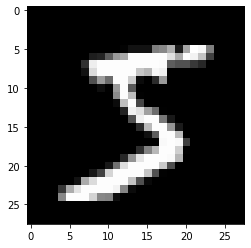

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape) ## 28x28 이미지가 펼쳐서 784 하나의 행으로 이루어진 것을 알 수 있음

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
    
def model(xb):
    return log_softmax(xb @ weights + bias) ## @는 내적계산

In [7]:
bs = 64 # 배치 사이즈

xb = x_train[0:bs] # x로부터 미니배치 설정
preds = model(xb) # 예측
preds[0], preds.shape
print(preds[0], preds.shape)


tensor([-2.1391, -2.9190, -2.6192, -1.9764, -2.0676, -2.5383, -2.5409, -2.0428,
        -2.3984, -2.1892], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [10]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()
    
loss_func = nll

In [11]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2492, grad_fn=<NegBackward0>)


In [12]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [13]:
print(accuracy(preds, yb))


tensor(0.1719)


In [14]:
from IPython.core.debugger import set_trace

lr = 0.5 # 학습률
epochs = 2 # 훈련에 사용될 에포크 수

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = (i+1)*bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0826, grad_fn=<NegBackward0>) tensor(1.)
